<a href="https://colab.research.google.com/github/92kareeem/AI/blob/main/Emotion_Recognition_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import requests
from io import StringIO

# Function to load the dataset
def load_goemotions(file_url):
    response = requests.get(file_url)
    response.raise_for_status()  # Ensure successful download
    return pd.read_csv(StringIO(response.text), sep='\t', names=["text", "labels", "comment_id"])

# URLs for GoEmotions dataset
train_url = "https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/train.tsv"
dev_url = "https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/dev.tsv"
test_url = "https://raw.githubusercontent.com/google-research/google-research/master/goemotions/data/test.tsv"

# Load datasets
train_df = load_goemotions(train_url)
dev_df = load_goemotions(dev_url)
test_df = load_goemotions(test_url)

# Combine datasets
data = pd.concat([train_df, dev_df, test_df], ignore_index=True)

# Emotion ID to label mapping
emotion_map = {
    0: "admiration", 1: "amusement", 2: "anger", 3: "annoyance", 4: "approval",
    5: "caring", 6: "confusion", 7: "curiosity", 8: "desire", 9: "disappointment",
    10: "disapproval", 11: "disgust", 12: "embarrassment", 13: "excitement",
    14: "fear", 15: "gratitude", 16: "grief", 17: "joy", 18: "love",
    19: "nervousness", 20: "optimism", 21: "pride", 22: "realization", 23: "relief",
    24: "remorse", 25: "sadness", 26: "surprise", 27: "neutral"
}

# Define target categories
required_categories = {
    "joy": ["admiration", "amusement", "joy", "gratitude", "love", "optimism", "pride"],
    "anger": ["anger", "annoyance", "disapproval", "disgust"],
    "sadness": ["grief", "disappointment", "remorse", "sadness"],
    "fear": ["fear", "nervousness"],
    "surprise": ["surprise", "excitement"],
    "neutral": ["neutral"]
}

# Create reverse mapping from emotion labels to target categories
reverse_map = {v: k for k, emotions in required_categories.items() for v in emotions}

# Function to map emotions to categories
def map_emotions(row_labels):
    labels = [emotion_map[int(idx)] for idx in row_labels.split(",")]
    for label in labels:
        if label in reverse_map:
            return reverse_map[label]
    return None

# Filter the dataset for target categories
data["category"] = data["labels"].apply(map_emotions)
data = data.dropna(subset=["category"]).reset_index(drop=True)

# Print summary
print("Filtered dataset shape:", data.shape)
print(data["category"].value_counts())


Filtered dataset shape: (46089, 4)
category
neutral     16733
joy         15736
anger        7594
sadness      3180
surprise     2004
fear          842
Name: count, dtype: int64


2.Exploratory Data Analysis

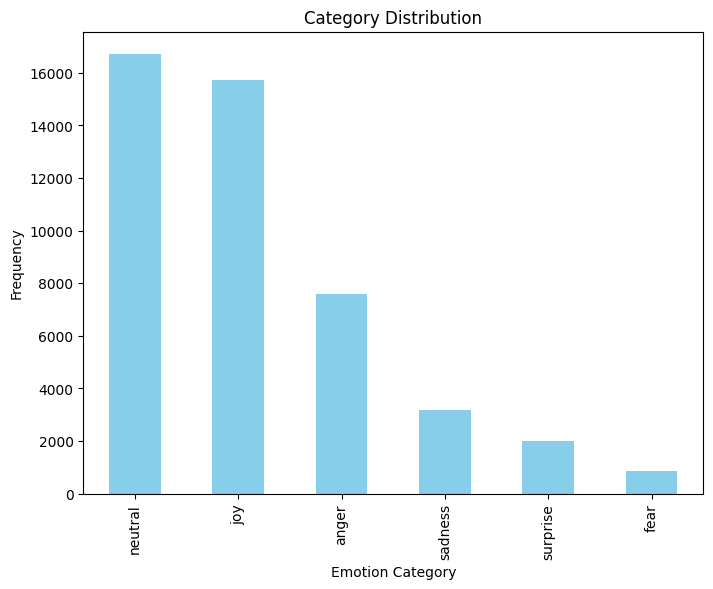

In [5]:
import matplotlib.pyplot as plt

# Category distribution
category_counts = data["category"].value_counts()

# Plot distribution
plt.figure(figsize=(8, 6))
category_counts.plot(kind="bar", color="skyblue")
plt.title("Category Distribution")
plt.xlabel("Emotion Category")
plt.ylabel("Frequency")
plt.show()

2. Text Pre-Processing

In [9]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z]", " ", text)  # Remove non-alphanumeric
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopwords.words("english")]
    return " ".join(tokens)

# Apply preprocessing
data["clean_text"] = data["text"].apply(preprocess_text)

# Split the data
X = data["clean_text"]
y = data["category"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


3.Feature Engineering

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


4.Model Training and Evaluation

Classification Report:
               precision    recall  f1-score   support

       anger       0.63      0.40      0.49      1519
        fear       0.73      0.33      0.46       168
         joy       0.82      0.80      0.81      3147
     neutral       0.61      0.83      0.70      3347
     sadness       0.73      0.41      0.52       636
    surprise       0.59      0.27      0.38       401

    accuracy                           0.69      9218
   macro avg       0.69      0.51      0.56      9218
weighted avg       0.69      0.69      0.67      9218



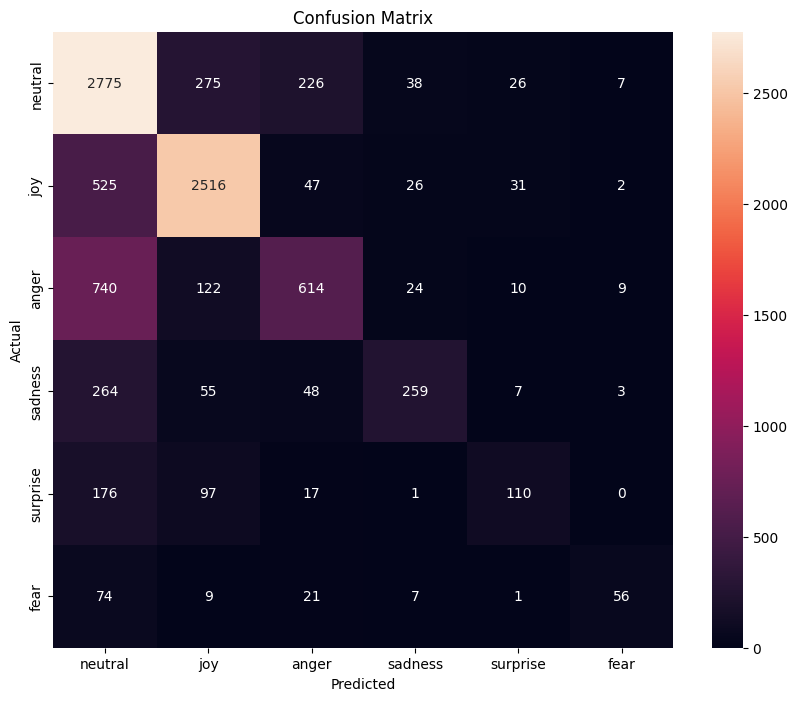

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Train Logistic Regression Model
model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train)

# Predictions
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=category_counts.index)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=category_counts.index, yticklabels=category_counts.index)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
